In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import print_metrics, train_model, count_parameters
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# use data augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
# load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# create data loaders
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Number of trainable parameters: 20490
Epoch: 1/10 	 Train loss: 1.265 	 Train accuracy: 0.644 	 val loss: 0.937 	 val accuracy: 0.722
Epoch: 2/10 	 Train loss: 0.882 	 Train accuracy: 0.719 	 val loss: 0.827 	 val accuracy: 0.739
Epoch: 3/10 	 Train loss: 0.799 	 Train accuracy: 0.740 	 val loss: 0.751 	 val accuracy: 0.758
Epoch: 4/10 	 Train loss: 0.753 	 Train accuracy: 0.750 	 val loss: 0.733 	 val accuracy: 0.763
Epoch: 5/10 	 Train loss: 0.724 	 Train accuracy: 0.760 	 val loss: 0.701 	 val accuracy: 0.772
Epoch: 6/10 	 Train loss: 0.700 	 Train accuracy: 0.764 	 val loss: 0.675 	 val accuracy: 0.781
Epoch: 7/10 	 Train loss: 0.689 	 Train accuracy: 0.770 	 val loss: 0.679 	 val accuracy: 0.780
Epoch: 8/10 	 Train loss: 0.675 	 Train accuracy: 0.773 	 val loss: 0.660 	 val accuracy: 0.778
Epoch: 9/10 	 Train loss: 0.665 	 Train accuracy: 0.776 	 val loss: 0.621 	 val accuracy: 0.795
Epoch: 10/10 	 Train loss: 0.657 	 Train accuracy: 0.782 	 val loss: 0.634 	 val accuracy: 0.795


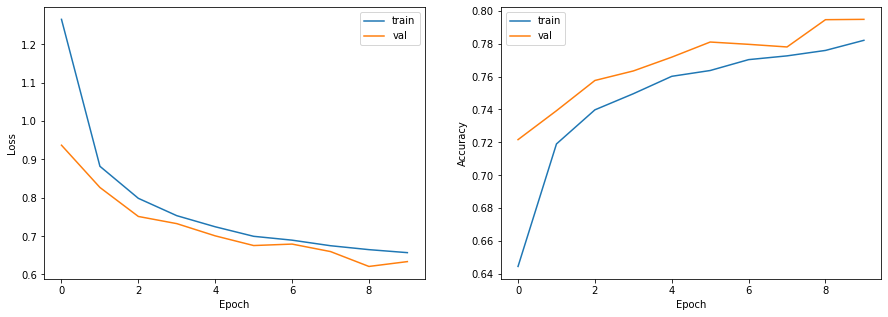

In [3]:
# load ResNet50 model using timm
model = timm.create_model('resnet50', pretrained=True)
# change the last layer to 10 classes
model.fc = nn.Linear(2048, 10)
# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# move model to GPU
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Number of trainable parameters: {}".format(count_parameters(model)))
# use train_model function to train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    airplane     0.7716    0.8410    0.8048      1000
  automobile     0.8830    0.9060    0.8944      1000
        bird     0.7797    0.7470    0.7630      1000
         cat     0.6557    0.6970    0.6757      1000
        deer     0.8274    0.7190    0.7694      1000
         dog     0.7687    0.7510    0.7597      1000
        frog     0.8516    0.8610    0.8563      1000
       horse     0.8301    0.8010    0.8153      1000
        ship     0.8619    0.8800    0.8709      1000
       truck     0.8647    0.8820    0.8733      1000

    accuracy                         0.8085     10000
   macro avg     0.8094    0.8085    0.8083     10000
weighted avg     0.8094    0.8085    0.8083     10000



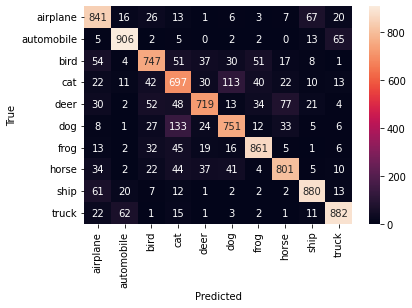

In [4]:
 # test the model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)

In [5]:
# load ResNet18 model
student_model = timm.create_model('resnet18', pretrained=True)
# change the last layer to 10 classes
student_model.fc = nn.Linear(512, 10)
# move model to GPU
student_model = student_model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)

In [6]:
# define a function to find the best alpha and T
def find_best_alpha_T(student_model, teacher_model, train_loader, test_loader, criterion, optimizer, epochs=10, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9]):
    best_acc = 0
    best_alpha = 0
    best_T = 0
    for T in T_list:
        for alpha in alpha_list:
            print(f'alpha={alpha}, T={T}')
            student_model = timm.create_model('resnet18', pretrained=True)
            student_model.fc = nn.Linear(512, 10)
            student_model = student_model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
            train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, test_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=T, alpha=alpha)
            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]
                best_alpha = alpha
                best_T = T
    return best_acc, best_alpha, best_T


In [7]:
# find the best alpha and T
best_acc, best_alpha, best_T = find_best_alpha_T(student_model, model, train_loader, val_loader, criterion, optimizer, epochs=4, T_list=[1, 10, 20], alpha_list=[0.1, 0.5, 0.9])

alpha=0.1, T=1
Epoch: 1/4 	 Train loss: 1.156 	 Train accuracy: 0.778 	 val loss: 1.119 	 val accuracy: 0.796
Epoch: 2/4 	 Train loss: 1.080 	 Train accuracy: 0.838 	 val loss: 1.083 	 val accuracy: 0.835
Epoch: 3/4 	 Train loss: 1.059 	 Train accuracy: 0.849 	 val loss: 1.044 	 val accuracy: 0.859
Epoch: 4/4 	 Train loss: 1.044 	 Train accuracy: 0.859 	 val loss: 1.106 	 val accuracy: 0.824
alpha=0.5, T=1
Epoch: 1/4 	 Train loss: 0.927 	 Train accuracy: 0.812 	 val loss: 0.872 	 val accuracy: 0.844
Epoch: 2/4 	 Train loss: 0.812 	 Train accuracy: 0.881 	 val loss: 0.825 	 val accuracy: 0.886
Epoch: 3/4 	 Train loss: 0.783 	 Train accuracy: 0.903 	 val loss: 0.794 	 val accuracy: 0.892
Epoch: 4/4 	 Train loss: 0.763 	 Train accuracy: 0.919 	 val loss: 0.817 	 val accuracy: 0.895
alpha=0.9, T=1
Epoch: 1/4 	 Train loss: 0.678 	 Train accuracy: 0.803 	 val loss: 0.612 	 val accuracy: 0.830
Epoch: 2/4 	 Train loss: 0.490 	 Train accuracy: 0.878 	 val loss: 0.487 	 val accuracy: 0.874
Epoch

In [9]:
best_T, best_alpha = 10, 0.5 # From multiple experiments
print(f"Best T={best_T}, best alpha={best_alpha}")

Best T=10, best alpha=0.5


In [10]:
# train the student model with the best alpha and T
student_model = timm.create_model('resnet18', pretrained=True)
student_model.fc = nn.Linear(512, 10)
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=10, alpha=best_alpha)

Epoch: 1/10 	 Train loss: 114.021 	 Train accuracy: 0.829 	 val loss: 114.115 	 val accuracy: 0.812
Epoch: 2/10 	 Train loss: 113.880 	 Train accuracy: 0.888 	 val loss: 113.870 	 val accuracy: 0.886
Epoch: 3/10 	 Train loss: 113.828 	 Train accuracy: 0.913 	 val loss: 113.968 	 val accuracy: 0.887
Epoch: 4/10 	 Train loss: 113.804 	 Train accuracy: 0.924 	 val loss: 113.846 	 val accuracy: 0.910
Epoch: 5/10 	 Train loss: 113.780 	 Train accuracy: 0.936 	 val loss: 113.835 	 val accuracy: 0.913
Epoch: 6/10 	 Train loss: 113.758 	 Train accuracy: 0.943 	 val loss: 113.836 	 val accuracy: 0.921
Epoch: 7/10 	 Train loss: 113.744 	 Train accuracy: 0.953 	 val loss: 113.794 	 val accuracy: 0.923
Epoch: 8/10 	 Train loss: 113.734 	 Train accuracy: 0.958 	 val loss: 113.839 	 val accuracy: 0.915
Epoch: 9/10 	 Train loss: 113.726 	 Train accuracy: 0.964 	 val loss: 113.803 	 val accuracy: 0.931
Epoch: 10/10 	 Train loss: 113.721 	 Train accuracy: 0.967 	 val loss: 113.773 	 val accuracy: 0.926

              precision    recall  f1-score   support

    airplane     0.9697    0.8630    0.9132      1000
  automobile     0.9687    0.9580    0.9633      1000
        bird     0.9310    0.9040    0.9173      1000
         cat     0.8604    0.8570    0.8587      1000
        deer     0.8748    0.9640    0.9172      1000
         dog     0.9123    0.8840    0.8979      1000
        frog     0.9339    0.9750    0.9540      1000
       horse     0.9672    0.9440    0.9555      1000
        ship     0.9251    0.9760    0.9499      1000
       truck     0.9524    0.9600    0.9562      1000

    accuracy                         0.9285     10000
   macro avg     0.9295    0.9285    0.9283     10000
weighted avg     0.9295    0.9285    0.9283     10000



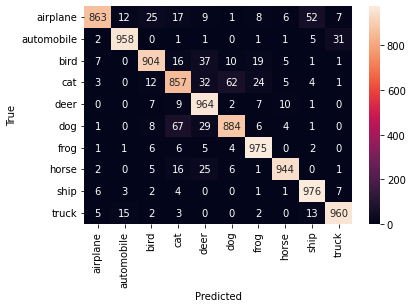

Number of trainable parameters: 11181642


In [11]:
# test the student model on test data
print_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

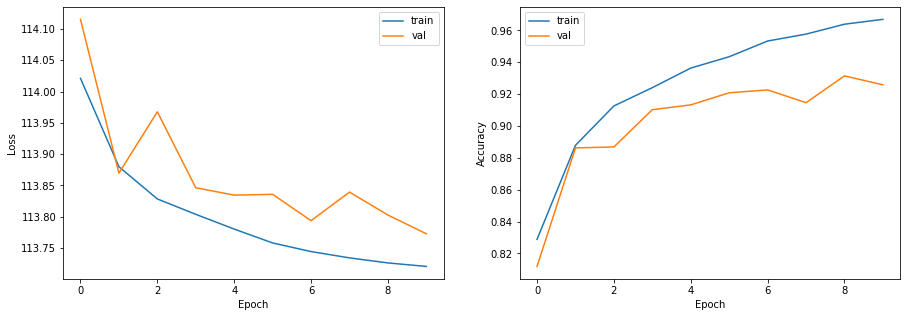

In [12]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# fine-tune all of resnet18 model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/10 	 Train loss: 0.615 	 Train accuracy: 0.789 	 val loss: 0.550 	 val accuracy: 0.815
Epoch: 2/10 	 Train loss: 0.383 	 Train accuracy: 0.868 	 val loss: 0.386 	 val accuracy: 0.872
Epoch: 3/10 	 Train loss: 0.307 	 Train accuracy: 0.895 	 val loss: 0.328 	 val accuracy: 0.892
Epoch: 4/10 	 Train loss: 0.260 	 Train accuracy: 0.911 	 val loss: 0.344 	 val accuracy: 0.890
Epoch: 5/10 	 Train loss: 0.219 	 Train accuracy: 0.926 	 val loss: 0.323 	 val accuracy: 0.893
Epoch: 6/10 	 Train loss: 0.195 	 Train accuracy: 0.932 	 val loss: 0.283 	 val accuracy: 0.905
Epoch: 7/10 	 Train loss: 0.170 	 Train accuracy: 0.941 	 val loss: 0.302 	 val accuracy: 0.902
Epoch: 8/10 	 Train loss: 0.153 	 Train accuracy: 0.947 	 val loss: 0.252 	 val accuracy: 0.917
Epoch: 9/10 	 Train loss: 0.134 	 Train accuracy: 0.953 	 val loss: 0.280 	 val accuracy: 0.910
Epoch: 10/10 	 Train loss: 0.126 	 Train accuracy: 0.956 	 val loss: 0.261 	 val accuracy: 0.922


              precision    recall  f1-score   support

    airplane     0.9051    0.9350    0.9198      1000
  automobile     0.9378    0.9800    0.9584      1000
        bird     0.9163    0.8760    0.8957      1000
         cat     0.9030    0.7820    0.8382      1000
        deer     0.9372    0.9260    0.9316      1000
         dog     0.8109    0.9390    0.8703      1000
        frog     0.9369    0.9500    0.9434      1000
       horse     0.9757    0.9240    0.9492      1000
        ship     0.9612    0.9420    0.9515      1000
       truck     0.9427    0.9550    0.9488      1000

    accuracy                         0.9209     10000
   macro avg     0.9227    0.9209    0.9207     10000
weighted avg     0.9227    0.9209    0.9207     10000



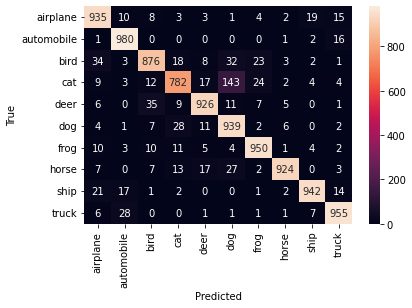

Number of trainable parameters: 11181642


In [14]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

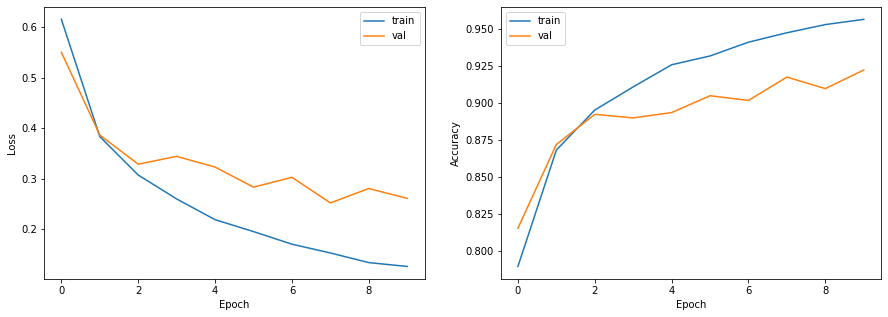

In [15]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# fine-tune all of resnet50 model
model = timm.create_model('resnet50', pretrained=True)
model.fc = nn.Linear(2048, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)


Epoch: 1/10 	 Train loss: 0.338 	 Train accuracy: 0.890 	 val loss: 0.180 	 val accuracy: 0.937
Epoch: 2/10 	 Train loss: 0.152 	 Train accuracy: 0.948 	 val loss: 0.144 	 val accuracy: 0.952
Epoch: 3/10 	 Train loss: 0.111 	 Train accuracy: 0.963 	 val loss: 0.182 	 val accuracy: 0.940
Epoch: 4/10 	 Train loss: 0.089 	 Train accuracy: 0.970 	 val loss: 0.187 	 val accuracy: 0.940
Epoch: 5/10 	 Train loss: 0.078 	 Train accuracy: 0.974 	 val loss: 0.138 	 val accuracy: 0.956
Epoch: 6/10 	 Train loss: 0.069 	 Train accuracy: 0.977 	 val loss: 0.178 	 val accuracy: 0.946
Epoch: 7/10 	 Train loss: 0.061 	 Train accuracy: 0.979 	 val loss: 0.155 	 val accuracy: 0.951
Epoch: 8/10 	 Train loss: 0.057 	 Train accuracy: 0.980 	 val loss: 0.167 	 val accuracy: 0.950
Epoch: 9/10 	 Train loss: 0.049 	 Train accuracy: 0.983 	 val loss: 0.178 	 val accuracy: 0.949
Epoch: 10/10 	 Train loss: 0.044 	 Train accuracy: 0.985 	 val loss: 0.168 	 val accuracy: 0.947


              precision    recall  f1-score   support

    airplane     0.9602    0.9660    0.9631      1000
  automobile     0.9152    0.9930    0.9525      1000
        bird     0.9781    0.9390    0.9582      1000
         cat     0.9276    0.8710    0.8984      1000
        deer     0.9326    0.9830    0.9572      1000
         dog     0.8842    0.9540    0.9177      1000
        frog     0.9779    0.9730    0.9754      1000
       horse     0.9937    0.9420    0.9671      1000
        ship     0.9736    0.9580    0.9657      1000
       truck     0.9853    0.9360    0.9600      1000

    accuracy                         0.9515     10000
   macro avg     0.9528    0.9515    0.9515     10000
weighted avg     0.9528    0.9515    0.9515     10000



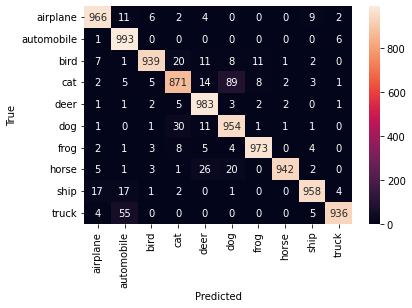

Number of trainable parameters: 11181642


In [17]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

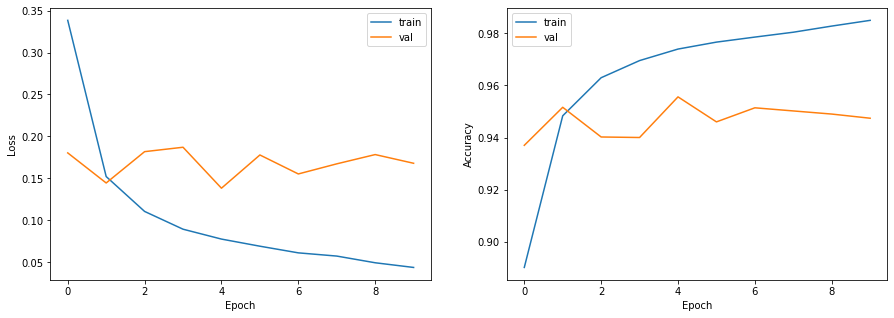

In [18]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()